<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/S_OD_Tilling_Aproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Object Detection: An Image Tilling Based Aprroach

## Abstract

Computer vision is a challenging task as machine sees numbers, unlike we humans.
The computer has to detect and classify objects present in an image to perceive as we humans do.
Most of the popuar object detector like RCNN-family or Yolo-Family detect medium and large objects well but they find difficulty in detecting small objects.
Most of these detectors use CNN to extract features for Object Localization and Object Classiifcation.
The features of smalle objects may disappear in deeper layers and it becomes difficult for the detector to detect small objects.
One solution is to use hig-resolution images for S-OD.
But training images with high resolution will be slow and needs huge GPU memory.
The inference time is also more for High Resolution images.
To overcome this difficulty we have used an image tiling based approach to detect samll objects.
Custom Yllov4 (small) is used for transfer learning and detections are performed on CPU performance evaluation.
The metric used for evaluation is mAP.
Finally, the model is deployed in the local cloud and a GUI is developed to do object detections locally.


## Introduction

CV is a challenging task --> computer see images as numbers.
OD --> Object locatization + classification
OD --> most applicable CV task
S-OD --> detect small objects --> desapears in deeper layers
High resolution Images --> Computer restritment

## Related Works

The annotation classes is some thing important.
Localization + classification --> Detection

YoloV3 is not able to detect objects less than 8px because the detection grids are subsampled with factors of 32, 16, 8.
Sumbsample using 4.
Remove backbone --> Darknet-53 --> last two Conv blocks --> huge number of parameters --> are not useful in S-OD.
3 levels detection --> search and detect objects in different scales.

Righ-resolution Detection Network --> HRDNet --> Multi-Depth Image Pyramid Network, Multi-Scale Feature Pyramid Network - MS-FPN.
Input I0 dimensions are reduced by a factor alpha --> extract features.
MD-IPN --> generates multi-scale and multi-leval features.

Given an input image, it is scalled down and scaled up and using shared CNN, and response maps and is merged for final detection.

Simplest architecture --> S-OD.
Feature maps from 3rd, 4th, 5th layers is concatened and feed a fully connected network.
Images from 16x16 and 42x42.

Tile techinique:
* Splitting image into tiles
* Use of temporal nature of images for background subtraction
* Modifying anchor sizes in the detector

## Data Collection

VEDAI --> Vehicle Detection in Aerial Imagery -- dataset

## Exploratory D|ata Analysis

VEDAI --> 1024 x 1024

The annotation is stored in a separated zip file.


In [ ]:
# Getting zip files
import requests
import zipfile
from pathlib import Path

# setup path to a datafolder
data_path = Path("data/")
image_path = data_path / "zipes"

# if the image folder does not exist, downlowd it and prepara it
if image_path.is_dir():
  print(f"{image_path} directory alredy exist... skipping download")
else:
  print("Image path does not exist, building it")
  image_path.mkdir(parents=True, exist_ok=True)

# Now downloading the zips - replace the withs below by a loo
for i in range(5):
  i +=1
  #tar_file = f"part{i}.tar"
  url = f"https://downloads.greyc.fr/vedai/Vehicules1024.tar.00{i}"
  local_file = data_path / f"Vehicules1024.tar.00{i}"
  print(f"Downloading {url}")
  request = requests.get(url)

  with open(local_file, "wb") as f:
    f.write(request.content)
  print(f"Saved {local_file}")

  # with open(data_path / tar_file,"wb") as f:
  #   print(f"Donwloading part {i}\n")
  #   request = requests.get(f"https://downloads.greyc.fr/vedai/Vehicules1024.tar.00{i}")
  #   print(f"Donwloaded part {i}.tar\n")
  #   f.write(request.content)

Image path does not exist, building it
Saved data/Vehicules1024.tar.001
Saved data/Vehicules1024.tar.002
Saved data/Vehicules1024.tar.003
Saved data/Vehicules1024.tar.004
Saved data/Vehicules1024.tar.005


In [ ]:
## Getting the annotations
with open(data_path / "Annotations1024.tar", "wb") as d:
  print("Downloading annotations\n")
  request = requests.get("https://downloads.greyc.fr/vedai/Annotations1024.tar")
  print("Downloaded annotations\n")
  d.write(request.content)


Downloaded annotations



In [ ]:
# Unziping the files
import tarfile

# 1. Concatenate all thre TAR files into one

with open(data_path / "Vehicules1024.tar","wb") as outfile:
  for i in range(5):
    i +=1
    part_file = data_path /f"Vehicules1024.tar.00{i}"
    with open(part_file, "rb") as infile:
      outfile.write(infile.read())
      print(f"Tar file {outfile} concatened")

Tar file <_io.BufferedWriter name='data/Vehicules1024.tar'> concatened
Tar file <_io.BufferedWriter name='data/Vehicules1024.tar'> concatened
Tar file <_io.BufferedWriter name='data/Vehicules1024.tar'> concatened
Tar file <_io.BufferedWriter name='data/Vehicules1024.tar'> concatened
Tar file <_io.BufferedWriter name='data/Vehicules1024.tar'> concatened


In [ ]:
# Now extract the final tar
tar_path = data_path / "Vehicules1024.tar"
with tarfile.open(tar_path, "r") as tar_ref:
  print(f"Extracting {tar_path}")
  tar_ref.extractall(image_path)
  print(f"{tar_path} extracted into {image_path}")

Extracting data/Vehicules1024.tar


/tmp/ipython-input-4129814153.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(image_path)


data/Vehicules1024.tar extracted into data/zipes


In [ ]:
# Now extract the annotations
tar_path = data_path / "Annotations1024.tar"
with tarfile.open(tar_path, "r") as tar_ref:
  print(f"Extracting {tar_path}")
  tar_ref.extractall(image_path)
  print(f"{tar_path} extracted into {image_path}")

Extracting data/Annotations1024.tar


/tmp/ipython-input-3956873498.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(image_path)


data/Annotations1024.tar extracted into data/zipes


In [ ]:
#from __future__ import annotations
# Now lets find the distribution of classes and percentage area of objects in the dataset
import os
import cv2
import pandas as pd

def know_data(path, annot_path):
  percentage_area = []
  classes = []
  for image in os.listdir(path):
    if image.endswith("_co.png"):
      # print(f"path: {path}")
      # print(f"image: {image}")
      im = cv2.imread(str(path / image))
      #print(f"img: {im}")
      h, w, _ = im.shape
      annot_name = image.replace("_co.png", ".txt")

      if not os.path.exists(annot_path / annot_name):
        continue

      annotations = pd.read_csv(annot_path / annot_name, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
      annotations["w"] = annotations[["x1", "x2", "x3", "x4"]].max(axis = 1) - annotations[["x1", "x2", "x3", "x4"]].min(axis = 1)
      annotations["h"] = annotations[["y1", "y2", "y3", "y4"]].max(axis = 1) - annotations[["y1", "y2", "y3", "y4"]].min(axis = 1)
      annotations["percentage"] = 100 * ( annotations["w"] * annotations["h"] ) / ( w * h )

      percentage_area.extend(annotations["percentage"].tolist())
      classes.extend(annotations["class"].tolist())

      # print(f"percentage_area: {percentage_area}\n")
      # print(f"classes: {classes}")

  return percentage_area, classes


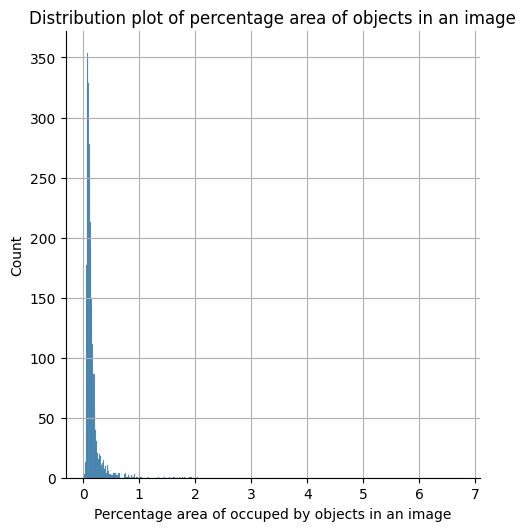

In [ ]:
# Now get the percentage area and classes from dataset
import seaborn as sns
import matplotlib.pyplot as plt

path = image_path / "Vehicules1024"
annot_path = image_path / "Annotations1024"
# print(f"path: {path}\n")
# print(f"annot_path: {annot_path}\n")
area, classes = know_data(path, annot_path)
# print(f"area: {area}")
# print(f"classes: {classes}")

# ploting the distribution of percentage area
sns.displot(x = area)
plt.xlabel("Percentage area of occuped by objects in an image")
plt.title("Distribution plot of percentage area of objects in an image")
plt.grid()
plt.show()

In [ ]:
# Qunaitle information of percentage area
s = pd.Series(area)
s.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

0.10    0.064087
0.20    0.076103
0.30    0.086117
0.40    0.097599
0.50    0.110149
0.60    0.126457
0.70    0.146866
0.80    0.178204
0.90    0.250187
0.99    0.913742
dtype: float64

In [ ]:
# defining a function to see the distribution of the data
from collections import Counter
def plot_distribution(classes, name):
  counter = Counter(classes)
  print(name, counter)
  plt.figure()
  plt.bar(counter.keys(), counter.values())
  plt.xlabel("Class")
  plt.ylabel("Object points per class")
  plt.title(f"Distribution of classes in {str(name)}")

Entire dataset: Counter({1: 1408, 11: 955, 5: 397, 2: 307, 10: 204, 4: 190, 23: 171, 9: 101, 31: 48, 7: 4, 8: 3})


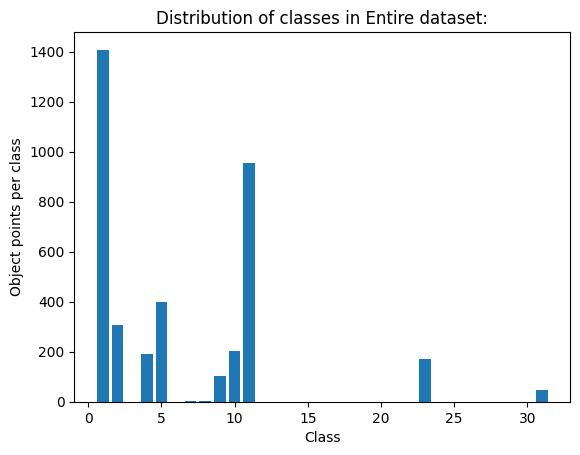

In [ ]:
# Ploting the distribution of classes
plot_distribution(classes, "Entire dataset:")

Is observable that 99.9% of the images has the target object that occupies less that 1% of the image area.
And 90% of the images has objects that occupies less than 0.25% of the images area.

From the above output, we can see that that there are 4 and 3 objects of **motorcycle** and **bus** in the entire dataset. So, we ignored these two classes for the object detection task.

**truck, pickup, and van** classes.

## **Preprocessing**

Let us split the data into train, cross-validation (cv) and test sets.

In [ ]:
import shutil

def make_datasets(src1, src2, dstn, sample=None):
  """
    This function makes datasets;
    If samples is None, then all the files from src1 and src2 are moved to dstn
    else a sample of them is moved from src1, src2 to dstn
  """
  src1 = Path(src1)
  src2 = Path(src2)
  dstn = Path(dstn)
  dstn.mkdir(parents=True, exist_ok=True)  # ensures that the folder exists

  files = os.listdir(src1)

  if sample is None:
    for file in files:
      f2 = file.replace("_co.png",".txt")
      #if os.path.exists(src2 / f2):
      if (src2 / f2).exists():
        print(f"src2: {src2}")
        print(f"f2: {f2}")
        shutil.move(src1 / file, dstn / f2.replace(".txt",".png"))
        shutil.move(src2 / f2, dstn / f2)

  else:
    for n in sample:
      f2 = files[n].replace("_co.png",".txt")
      #if os.path.exists(src2 / f2):
      if (src2 / f2).exists():
        shutil.move(src1 / files[n], dstn / f2.replace(".txt",".png"))
        shutil.move(src2 / f2, dstn / f2)

In [ ]:
# test datase
import random

test_sample = random.sample(range(len(os.listdir(path))), int(0.2 * len(os.listdir(path))))
make_datasets(path,annot_path,"./data/zipes/test", test_sample)

In [ ]:
# cv
cv_sample = random.sample(range(len(os.listdir(path))),int(0.25 * len(os.listdir(path))))
make_datasets(path,annot_path, "./data/zipes/cv", cv_sample)

In [ ]:
# train
make_datasets(path, annot_path,"./data/zipes/train")

print(len(os.listdir("./data/zipes/train")), len(os.listdir("./data/zipes/cv")), len(os.listdir("./data/zipes/test")))

src2: data/zipes/Annotations1024
f2: 00000849.txt
src2: data/zipes/Annotations1024
f2: 00001148.txt
src2: data/zipes/Annotations1024
f2: 00000331.txt
src2: data/zipes/Annotations1024
f2: 00000845.txt
src2: data/zipes/Annotations1024
f2: 00000886.txt
src2: data/zipes/Annotations1024
f2: 00001232.txt
src2: data/zipes/Annotations1024
f2: 00000042.txt
src2: data/zipes/Annotations1024
f2: 00000820.txt
src2: data/zipes/Annotations1024
f2: 00000588.txt
src2: data/zipes/Annotations1024
f2: 00000816.txt
src2: data/zipes/Annotations1024
f2: 00000667.txt
src2: data/zipes/Annotations1024
f2: 00000356.txt
src2: data/zipes/Annotations1024
f2: 00000046.txt
src2: data/zipes/Annotations1024
f2: 00000157.txt
src2: data/zipes/Annotations1024
f2: 00000574.txt
src2: data/zipes/Annotations1024
f2: 00000238.txt
src2: data/zipes/Annotations1024
f2: 00001040.txt
src2: data/zipes/Annotations1024
f2: 00001105.txt
src2: data/zipes/Annotations1024
f2: 00000966.txt
src2: data/zipes/Annotations1024
f2: 00000860.txt


There are 11 classes for object detection in the dataset.
We have ignored two classes namely **motorcycle** and **bus**.
Let us make class labels from 1 to 9 and plot the distribution of classes in the train, cv, and test sets.

In [ ]:
# A function to polot the distribution of classes in the datasets

def data_know(path):
  """
  original class: 7- motorcycle and 8- bus has 3 and 4 objects respectively in total.
  So, removing them.
  """

  '''
  car-1
  truck-2
  plane-3
  tractor-4
  camping_car-5
  boat-6
  pickup-7
  other-8
  van-9
  '''

  classes = []

  for image in os.listdir(path):
    if image.endswith(".png"):
      img = cv2.imread(str(path + image))
      h, w, _ = img.shape
      annot_name = image.replace(image.split(".")[-1],"txt")
      annotations = pd.read_csv(str(path + annot_name), sep = " ", names = ["xc","yc","angle","class","isEntire","occluded","x1","x2","x3","x4","y1","y2","y3","y4"])
      annotations = annotations[annotations["class"].isin([1,2,4,5,9,10,11,23,31])]
      annotations["class"].replace(31,3,inplace = True)
      annotations["class"].replace(23,6,inplace = True)
      annotations["class"].replace(11,7,inplace = True)
      annotations["class"].replace(10,8,inplace = True)
      annotations["w"] = annotations[["x1","x2","x3","x4"]].max(axis=1) - annotations[["x1", "x2", "x3", "x4"]].min(axis = 1)
      annotations["w"] = annotations[["y1","y2","y3","y4"]].max(axis=1) - annotations[["y1", "y2", "y3", "y4"]].min(axis = 1)
      classes.extend(annotations["class"].tolist())

  return classes



A saída de streaming foi truncada nas últimas 5000 linhas.

  annotations["class"].replace(23,6,inplace = True)
/tmp/ipython-input-3132493568.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations["class"].replace(11,7,inplace = True)
/tmp/ipython-input-3132493568.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we 

train_set:  Counter({1: 864, 7: 595, 5: 250, 2: 179, 8: 132, 6: 104, 4: 94, 9: 63, 3: 36})
test_set:  Counter({1: 260, 7: 178, 2: 57, 5: 55, 4: 43, 6: 36, 8: 28, 9: 21, 3: 3})
cv_set:  Counter({1: 284, 7: 182, 5: 92, 2: 71, 4: 53, 8: 44, 6: 31, 9: 17, 3: 9})


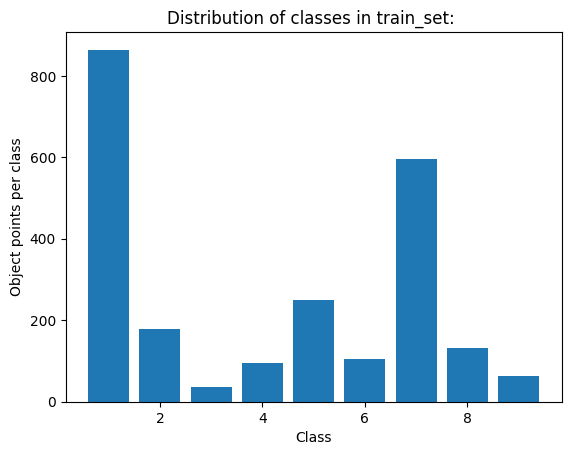

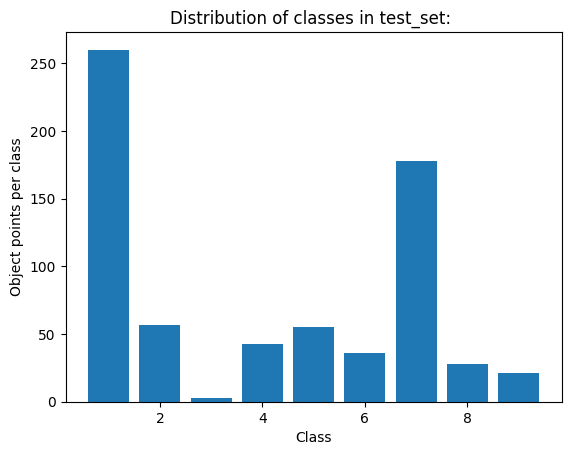

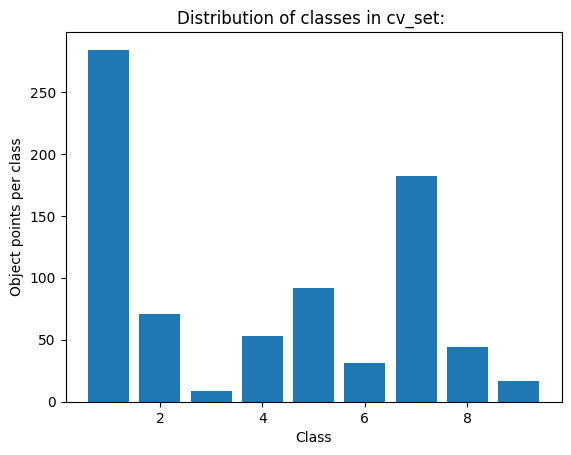

In [ ]:
# Now plotting class distribution
train_path = "./data/zipes/train/"
test_path = "./data/zipes/test/"
cv_path = "./data/zipes/cv/"
train_classes = data_know(train_path)
test_classes = data_know(test_path)
cv_classes = data_know(cv_path)

# plot
plot_distribution(train_classes, "train_set: ")
plot_distribution(test_classes, "test_set: ")
plot_distribution(cv_classes, "cv_set: ")

from the above plots, we can see that distribution of classes in all three train, cv, and test datasets is almost similar.

Now convert annotations to YOLO format.

In [ ]:
# a function to convert the annotations to YOLO format
def to_yolo(path):
  """
    This function converts annotations to YOLO format
  """

  for image in os.listdir(path):
    if image.endswith(".png"):
      img = cv2.imread(str(path + image))
      h, w, _ = img.shape
      annot_name = image.replace(image.split(".")[-1],"txt")

      if os.path.exists(str(path + annot_name)):
        annotations = pd.read_csv(str(path + annot_name), sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
        annotations.drop(columns = ["xc","yc","angle","isEntire","occluded"], inplace = True)
        annotations["class"].replace(31,3, inplace = True)
        annotations["class"].replace(23,6, inplace = True)
        annotations["class"].replace(11,7, inplace = True)
        annotations["class"].replace(10,8, inplace = True)
        annotations["class"] = annotations["class"] - 1
        annotations["xmin"] = annotations[["x1","x2","x3","x4"]].min(axis = 1)
        annotations["xmax"] = annotations[["x1","x2","x3","x4"]].max(axis = 1)
        annotations["ymin"] = annotations[["y1","y2","y3","y4"]].min(axis = 1)
        annotations["ymax"] = annotations[["y1","y2","y3","y4"]].max(axis = 1)
        annotations.drop(columns = ["x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"], inplace = True)
        annotations["xc"] = (annotations["xmin"] + annotations["xmax"])/2/w
        annotations["yc"] = (annotations["ymin"] + annotations["ymax"])/2/h
        annotations["w"] = (annotations["xmax"] + annotations["xmin"])/w
        annotations["h"] = (annotations["ymax"] + annotations["xmin"])/h
        annotations.drop(columns = ["xmin","xmax","ymin","ymax"], inplace=True)
        annotations.to_csv(str(path + annot_name), sep = " ", index = False, header = False, float_format = "%.6f")

      else:
        print(f"annotations not available for {str(annot_path + annot_name)}")

In [ ]:
to_yolo(train_path)

A saída de streaming foi truncada nas últimas 5000 linhas.

  annotations["class"].replace(23,6, inplace = True)
/tmp/ipython-input-3909392591.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations["class"].replace(11,7, inplace = True)
/tmp/ipython-input-3909392591.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

In [ ]:
to_yolo(cv_path)

A saída de streaming foi truncada nas últimas 5000 linhas.

  annotations["class"].replace(23,6, inplace = True)
/tmp/ipython-input-3909392591.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations["class"].replace(11,7, inplace = True)
/tmp/ipython-input-3909392591.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

In [ ]:
to_yolo(test_path)

A saída de streaming foi truncada nas últimas 5000 linhas.

  annotations["class"].replace(23,6, inplace = True)
/tmp/ipython-input-3909392591.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations["class"].replace(11,7, inplace = True)
/tmp/ipython-input-3909392591.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

Lets us sanity check our conversion to YOLO format.

In [ ]:
# a function to check the convert of annoations to YOLO format
import numpy as np

def display_images_and_labels(img_path):
  """
    A function to check the convert of annoations to YOLO format
  """

  annot_path = img_path.replace(".png",".txt")
  number_of_classes = 9  # get automatically
  colors = [
      (190, 200, 68),
      (125, 102, 60),
      (54, 186, 32),
      (246, 119, 66),
      (61, 196, 32),
      (139, 126, 1),
      (14, 40, 254),
      (55, 113, 168),
      (144, 45, 240),
      (127, 32, 61)
  ]

  obj_names = [
      "car",
      "truck",
      "plane",
      "tractor",
      "camping_car",
      "boat",
      "pickup",
      "other",
      "van"
  ]

  df = pd.read_csv(annot_path, sep= " ", names = ["class","xc","yc","w","h"])
  img = cv2.imread(img_path)
  h, w, _ = img.shape
  df["w"] = np.round(df["w"]*w)
  df["h"] = np.round(df["h"]*h)
  df["x1"] = np.round(df["xc"]*w - df["w"]/2)
  df["y1"] = np.round(df["yc"]*h - df["h"]/2)
  df["x2"] = np.round(df["xc"]*w + df["w"]/2)
  df["y2"] = np.round(df["yc"]*h + df["h"]/2)

  for index, row in df.iterrows():
    c = colors[int(row["class"])]

    cv2.rectangle(img,
                  (int(row["x1"]), int(row["y1"])),
                  (int(row["x2"]), int(row["y2"])),
                  c,2)

    cv2.putText(img, obj_names[int(row["class"])],
                (int(row["x1"]), int(row["y1"])-4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, c, 2, cv2.LINE_AA)

    # cv2.rectangle(img, (int(row["x"]), int(row["y"])), (int(row["x"]) + int(row["w"]), int(row["y"]) + int(row["h"])), (int(c[0]), int(c[1]), int(c[2])), 2)
    # cv2.putText(img, obj_names[int(row["class"])], (int(row["x"])-4, int(row["y"])-4), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[int(row["class"])], 1, cv2.LINE_AA)

  # if not IN_COLAB:
  #   cv2.imshow('image', img)
  #   cv2.waitKey(0)
  #   cv2.destroyAllWindows()

  # else:
  from google.colab.patches import cv2_imshow
  cv2_imshow(img)

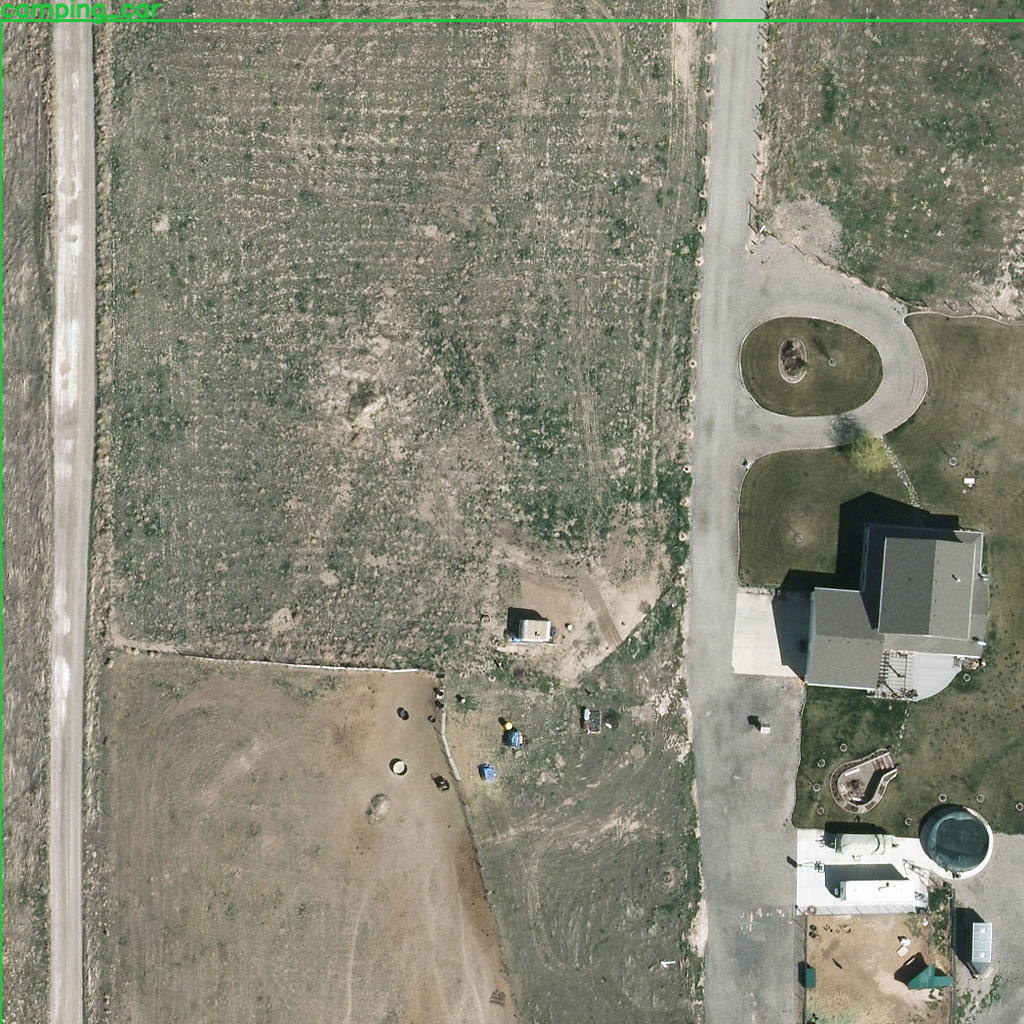

In [ ]:
display_images_and_labels("./data/zipes/train/00000003.png")

## Lets us convert the images into blocks of dimensions 416 x 416

In [ ]:
# Reference: https://github.com/slanj/yolo-tiling/blob/main/tile_yolo.py
# Code taken from above reference and modified to this problem

import math
from shapely.geometry import Polygon

def tiler(imgnames, newpath, falsepath, slice_size, ext):
  """
    blocks of slices_size x slice_size
  """

  if falsepath:
    os.makedirs(falsepath, exist_ok=True)

  for imgname in imgnames:
    # get the image properties
    img = cv2.imread(imgname)
    height, width, _ = img.shape
    h_new = math.ceil(height/slice_size) * slice_size
    w_new = math.ceil(width/slice_size) * slice_size
    img = cv2.resize(img, (w_new, h_new), cv2.INTER_LINEAR)

    labname =imgname.replace(ext,".txt")
    labels = pd.read_csv(labname, sep=" ", names=["class","x1","y1","w","h"])

    # we need to rescale coordinates from 0-1 to real image height and width
    labels[["x1","w"]] = labels[["x1","w"]] * w_new
    labels[["y1","h"]] = labels[["y1","h"]] * h_new

    boxes = []

    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for _,row in labels.iterrows():
      x1 = row["x1"] - row["w"]/2
      y1 = row["y1"] - row["h"]/2
      x2 = row["x1"] + row["w"]/2
      y2 = row["y1"] + row["h"]/2

      # skip degenerated boxes
      if x2 <= x1 or y2 <= y1:
        continue

      poly = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
      if not poly.is_valid:
        continue
      boxes.append((int(row["class"]), poly))

      # x1 = row[1]["x1"]- row[1]["w"]/2
      # y1 = (h_new - row[1]["y1"]) - row[1]["h"]/2
      # x2 = row[1]["x1"] + row[1]["w"]/2
      # y2 = (h_new - row[1]["y1"]) + row[1]["h"]/2

      #boxes.append((int(row[1]["class"]), Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])))

  # build tiles and find intersection with bounding boxes for each tile
  for i in range((h_new // slice_size)):  # i lines
    for j in range((w_new // slice_size)): # j rows
      x1 = j * slice_size
      y1 = i * slice_size
      x2 = (j+1) * slice_size
      y2 = (i+1) * slice_size

      # x1 = j*slice_size
      # y1 = h_new - (i*slice_size)  # i defines multiplicator factor to the initial position
      # x2 = ((j+1)*slice_size) - 1
      # y2 = (h_new - (i+1)*slice_size) + 1

      pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])  # buils the polygon coordinates
      imgsaved = False
      slice_labels = []

      # find the intersections of the Polygons
      for box in boxes:
        if pol.intersects(box[1]):
          inter = pol.intersection(box[1])

          if inter.is_empty:
            continue

          if inter.geom_type != "Polygon":
            continue

          # Get smallest rectangular polygon (with sides parallel to the coordinates axes) that contains the intersections
          new_box = inter.envelope
          # Get central point for the new bounding box
          centre = new_box.centroid
          # get the coordinates of polygon vertices
          x, y = new_box.exterior.coords.xy
          # get bouding box width and height normalized to slice size
          new_width = (max(x) - min(x)) / slice_size
          new_height = (max(y) - min(y)) / slice_size
          # we have to normalize central x and y for yolo format
          new_x = (centre.coords.xy[0][0] - x1) / slice_size
          new_y = (y1 - centre.coords.xy[1][0]) / slice_size
          slice_labels.append([box[0], new_x, new_y, new_width, new_height])

          if not imgsaved:
            #sliced_img = img[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
            sliced_img = img[y1:y2, x1:x2]
            #filename = imgname.split("/")[-1]
            filename = os.path.basename(imgname)
            #slice_path = newpath + "/" + filename.replace(ext, f"_{i}_{j}{ext}")
            slice_path = os.path.join(newpath, filename.replace(ext, f"_{i}_{j}{ext}"))
            #slice_labels_path = newpath + "/" + filename.replace(ext, f"_{i}_{j}.txt")
            cv2.imwrite(slice_path, slice_img)
            slice_labels_path = slice_path.replace(ext, ".txt")
            #print(slice_path)
            #sliced_img.save(slice_path)
            imgsaved = True

      if len(slice_labels) > 0:
        slice_df = pd.DataFrame(slice_labels, columns=["class","x1","y1","w","h"])
        #print(slice_df)
        slice_df.to_csv(slice_labels_path, sep=" ", index=False, header=False, float_format='%.6f')

      if not imgsaved and falsepath:
        #slice_img = img[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
        slice_img = img[y1:y2, x1:x2]
        #filename = imgname.split("/")[-1]
        filename = os.path.basename(imgname)
        #slice_path = falsepath + "/" + filename.replace(ext, f"_{i}_{j}{ext}")
        slice_path = os.path.join(falsepath, filename.replace(ext,f"_{i}_{j}{ext}"))
        #slice_img.save(slice_path)
        cv2.imwrite(slice_path, sliced_img)
        imgsaved = True

  print(f"Tiling succefully completed: {imgname}")

In [ ]:
from shapely.geometry import Polygon
import cv2, os, math
import pandas as pd
import numpy as np

def tiler2(imgnames, newpath, falsepath, slice_size, ext):
    os.makedirs(newpath, exist_ok=True)
    if falsepath:
        os.makedirs(falsepath, exist_ok=True)

    for imgname in imgnames:
        print(f"imgname: {imgname}")
        img = cv2.imread(imgname)
        height, width, _ = img.shape
        h_new = math.ceil(height/slice_size) * slice_size
        w_new = math.ceil(width/slice_size) * slice_size
        img = cv2.resize(img, (w_new, h_new), cv2.INTER_LINEAR)

        labname = imgname.replace(ext, ".txt")
        labels = pd.read_csv(labname, sep=" ", names=["class","x1","y1","w","h"])

        # convert YOLO → pixel coords
        labels[["x1","w"]] = labels[["x1","w"]] * w_new
        labels[["y1","h"]] = labels[["y1","h"]] * h_new

        boxes = []
        for _, row in labels.iterrows():
            x1 = row["x1"] - row["w"]/2
            y1 = row["y1"] - row["h"]/2
            x2 = row["x1"] + row["w"]/2
            y2 = row["y1"] + row["h"]/2

            # skip degenerate boxes
            if x2 <= x1 or y2 <= y1:
                continue

            poly = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
            if not poly.is_valid:
                continue
            boxes.append((int(row["class"]), poly))

        for i in range(h_new // slice_size):
            for j in range(w_new // slice_size):
                x1 = j * slice_size
                y1 = i * slice_size
                x2 = (j+1) * slice_size
                y2 = (i+1) * slice_size

                pol = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
                imgsaved = False
                slice_labels = []

                for box in boxes:
                    if pol.intersects(box[1]):
                        inter = pol.intersection(box[1])
                        if inter.is_empty or inter.geom_type != "Polygon":
                            continue
                        inter = inter.envelope
                        centre = inter.centroid
                        x, y = inter.exterior.coords.xy
                        new_width = (max(x)-min(x)) / slice_size
                        new_height = (max(y)-min(y)) / slice_size
                        new_x = (centre.x - x1) / slice_size
                        new_y = (centre.y - y1) / slice_size
                        slice_labels.append([box[0], new_x, new_y, new_width, new_height])

                        if not imgsaved:
                            sliced_img = img[y1:y2, x1:x2]
                            filename = os.path.basename(imgname)
                            slice_path = os.path.join(newpath, filename.replace(ext, f"_{i}_{j}{ext}"))
                            cv2.imwrite(slice_path, sliced_img)
                            slice_labels_path = slice_path.replace(ext, ".txt")
                            imgsaved = True

                if slice_labels:
                    slice_df = pd.DataFrame(slice_labels, columns=["class","x1","y1","w","h"])
                    slice_df.to_csv(slice_labels_path, sep=" ", index=False, header=False, float_format="%.6f")

                if not imgsaved and falsepath:
                    sliced_img = img[y1:y2, x1:x2]
                    filename = os.path.basename(imgname)
                    slice_path = os.path.join(falsepath, filename.replace(ext, f"_{i}_{j}{ext}"))
                    cv2.imwrite(slice_path, sliced_img)

        print(f"Tiling completed for {imgname}")


In [ ]:
ext = ".png"  # the file extension
size = 416 # the tile size - can be added by args - or automatic reshape according the image size

train_src = "./data/zipes/train/"
test_src = "./data/zipes/test/"
cv_src = "./data/zipes/cv/"

train_imgnames = [train_src + name for name in os.listdir(train_src) if name.endswith(ext)]
test_imgnames = [test_src + name for name in os.listdir(test_src) if name.endswith(ext)]
cv_imgnames = [cv_src + name for name in os.listdir(cv_src) if name.endswith(ext)]

tiler2(train_imgnames, "./data/zipes/train/train_tiled/", None, size, ext)

imgname: ./data/zipes/train/00000266.png
Tiling completed for ./data/zipes/train/00000266.png
imgname: ./data/zipes/train/00000063.png
Tiling completed for ./data/zipes/train/00000063.png
imgname: ./data/zipes/train/00001079.png
Tiling completed for ./data/zipes/train/00001079.png
imgname: ./data/zipes/train/00000410.png
Tiling completed for ./data/zipes/train/00000410.png
imgname: ./data/zipes/train/00001250.png
Tiling completed for ./data/zipes/train/00001250.png
imgname: ./data/zipes/train/00001098.png
Tiling completed for ./data/zipes/train/00001098.png
imgname: ./data/zipes/train/00000795.png
Tiling completed for ./data/zipes/train/00000795.png
imgname: ./data/zipes/train/00000645.png
Tiling completed for ./data/zipes/train/00000645.png
imgname: ./data/zipes/train/00000723.png
Tiling completed for ./data/zipes/train/00000723.png
imgname: ./data/zipes/train/00000355.png
Tiling completed for ./data/zipes/train/00000355.png
imgname: ./data/zipes/train/00000722.png
Tiling completed fo

In [ ]:
tiler2(test_imgnames, "./data/zipes/test/test_tiled/", None, size, ext)
tiler2(cv_imgnames, "./data/zipes/cv/cv_tiled/", None, size, ext)

imgname: ./data/zipes/test/00000676.png
Tiling completed for ./data/zipes/test/00000676.png
imgname: ./data/zipes/test/00000446.png
Tiling completed for ./data/zipes/test/00000446.png
imgname: ./data/zipes/test/00000790.png
Tiling completed for ./data/zipes/test/00000790.png
imgname: ./data/zipes/test/00000756.png
Tiling completed for ./data/zipes/test/00000756.png
imgname: ./data/zipes/test/00000316.png
Tiling completed for ./data/zipes/test/00000316.png
imgname: ./data/zipes/test/00000631.png
Tiling completed for ./data/zipes/test/00000631.png
imgname: ./data/zipes/test/00000523.png
Tiling completed for ./data/zipes/test/00000523.png
imgname: ./data/zipes/test/00000520.png
Tiling completed for ./data/zipes/test/00000520.png
imgname: ./data/zipes/test/00000832.png
Tiling completed for ./data/zipes/test/00000832.png
imgname: ./data/zipes/test/00000627.png
Tiling completed for ./data/zipes/test/00000627.png
imgname: ./data/zipes/test/00000687.png
Tiling completed for ./data/zipes/test/0

## Experiments and Results




## Data Pipeline

Below we will develop a code (function) to take image names as arguments adnd divides the images into blocks - tiles - and detects objects in individual blocks - tiles. Finaly, the blocks are stitched together and detected images are displayed.

In [ ]:
#from __future__ import annotations
# the data pipeline function
import time

def data_pipe_line(path, img_name):
  """
    Below we will develop a code (function) to take image names as arguments adnd divides the images into blocks - tiles -
    and detects objects in individual blocks - tiles.
    Finaly, the blocks are stitched together and detected images are displayed.
  """

  colors = [(190, 200, 68),
            (125, 102, 60),
            (54, 186, 32),
            (246, 119, 66),
            (61, 196, 32),
            (139, 126, 1),
            (14, 40, 254),
            (55, 113, 168),
            (144, 45, 240),
            (127, 32, 61)
              ]
  obj_names = [ "car",
               "truck",
                "plane",
                "tractor",
                "camping_car",
                "boat",
                "pickup",
                "other",
                "van"]

  # read image and make tiles each of dimensions size x size
  ext = img_name.split(".")[-1]
  img = cv2.imread(path + img_name)
  size = 416 # this parameter can be adjusted according the network input size
  h, w, _ = img.shape
  h_new = math.ceil(h/size) * size
  w_new = math.ceil(w/size) * size
  scale_h = h_new/h
  scale_w = w_new/w
  resized_img = cv2.resize(img, (w_new, h_new), cv2.INTER_LINEAR)

  # !rm -rf "/content/tiled_images/"
  # !mkdir "/content/tiled_images/"

  tiled_images_path = "./data/zipes/tiled_images_test/"

  tiled_img_list = []

  for i in range(h_new//size):
    for j in range(w_new//size):

      tiled = resized_img[i*size : (i+1)*size, j*size : (j+1)*size, :]
      tiled_img_name = tiled_images_path + img_name.split(".")[0] + "_" + str(i) + "_" + "." + ext
      tiled_img_list.append(tiled_img_name)
      df = pd.DataFrame(tiled_img_list)
      # Saving the path of tiled images so as to feed it to yolo model
      df.to_csv("./data/zipes/tiled_images_test.txt", index=False, header=False)  # check all the paths before
      # saving tiled image
      cv2.imwrite(tiled_img_name, tiled)

  # Detect objects on individual tiles and store detected objects in json format
  start = time.time()
  !./darknet detector test data/obj.data cfg/yolov4-tiny-custom.cfg /mygdrive/CS2/vedai/yolo/backup/yolov4-tiny-custom_best.weights -ext_output -dont_show -out /content/result.json  < /content/tiled_images.txt -thresh 0.1
  end = time.time()

# read objects location from json and store in .txt files
  f = open("/.data/result.json", )
  result = cv2.load(f)
  f.close

  for res in result:
    if len(res["objects"]) > 0:
      annot_path = res[f"filename"].replace("." + ext, ".txt")
      lines = []
      for obj in res["objects"]:
        coords = obj["relative_coordinates"]
        lines.append([obj["class_id"], coords["center_x"], coords["center_y"], coords["width"], coords["height"], obj["name"], obj["confidence"]])

      df = cv2.DataFrame(lines)
      # saving the location of detected objects
      df.to_csv(annot_path, sep = " ", index=False, header=False)

  # combine tiled images
  annotations_list = []
  col_list = []
  for i in range(cv2.ceil(h/size)):
    row_list = []
    for j in range(cv2.ceil(w/size)):
      tiled_image_name = tiled_images_path + img_name.split(".")[0] + "_" + str(i) + "_" + str(j) + "." + ext
      row_list.append(cv2.imread(tiled_image_name))
      annot_path = tiled_image_name.replace("." + ext, ".txt")

      if os.path.exists(annot_path):
        annotations = cv2.read_csv(annot_path, sep=" ", names=["class","xc","yc","yolo_w","yolo_h","obj_name","confidence"])

        # converting locations from yolo to pascal VOC format
        annotations["w"] = annotations["yolo_w"]*size
        annotations["h"] = annotations["yolo_h"]*size
        annotations["x"] = annotations["xc"]*size - annotations["w"]/2 + j*size
        annotations["y"] = annotations["yc"]*size - annotations["h"]/2 + i*size

        # scaling locations to original image
        annotations["w"] = cv2.round_(annotations["w"]/scale_w)
        annotations["h"] = cv2.round_(annotations["h"]/scale_h)
        annotations["x"] = cv2.round_(annotations["x"]/scale_w)
        annotations["y"] = cv2.round_(annotations["y"]/scale_w)

        annotations = annotations[["class","x","y","w","h","obj_name","confidence"]]
        annotations_list.append(annotations)

      # Reference: https://www.geeksforgeeks.org/concatenate-images-using-opencv-in-python/
    col_list.append(cv2.hconcat(row_list))

  scaled_image = cv2.vconcat(col_list)
  reconstructed_image = cv2.resize(scaled_image,(W, h), interpolation = cv2.INTER_AREA)

  if len(annotations_list) > 0:
    df = cv2.concat(annotations_list, axis=0)

    for index, row in df.iterrows():
      print(row["obj_name"])
      cv2.rectangle(reconstructed_image, (int(row["x"]), int(row["y"])), (int(row["x"]+row["w"]) , int(row["y"]+row["h"])), colors[obj_names.index(row["obj_name"])], 2)
      cv2.putText(reconstructed_image, row["obj_name"] + " "  + str(round(row["confidence"], 2)), (int(row["x"])-4, int(row["y"])-4), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[obj_names.index(row["obj_name"])], 1, cv2.LINE_AA)

  else:
    print("No object detected")
    cv2.imshow(reconstructed_image)




In [ ]:
# Confidence threshold
inference_path = "./data/zipes/test/"
image_name = "00000014.png"
data_pipe_line(inference_path, image_name)

/bin/bash: line 1: /content/tiled_images.txt: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/.data/result.json'

## TensorFlow and TensorFlowLite Conversion

Till now we used darknet repo for training the object detection model and inference.
This Github repo is used to convert YOLO Darknet v4 to TensorFlow and TensorFlow-lite versions.
Our best model is YOLOv4-Small is converted to TensorFlow and TensorFlow-lite.
Let's find the inference time in TensorFlow and TF-lite versions.

In [ ]:
# TensorFlow Function
def detect_tiless_tf(score: float, iou: float, input_size: float, image_path: str, weights_path: str):
  """
    This function print the time taken for OD in TF
  """

  img_name = image_path.split("/")[-1]
  # ext = img_name.split(".")[-1]   #check
  start = time()
  original_image = cv2.imread(image_path)
  h, w, _ = original_image.shape
  h_new = ceil(h/input_size) * input_size
  w_new = ceil(w/input_size) * input_size
  # scaled_h = h_new/h
  # scaled_w = w_new/w
  resized_image = cv2.resize(original_image, (w_new, h_new), cv2.INTER_LINEAR)

  col_list = []
  for i in range(h_new//input_size):
    row_list = []
    for j in range(w_new//input_size):
      tiled_image_original = resized_image[i*input_size : (i+1)*input_size, j*input_size : (j+1)*input_size, :]
      tiled_image = tiled_image_original / 255.0
      tilled_image = np.asarray(tiled_image).astype(np.float32)

      saved_model_loaded = tf.saved_model.load(weights_path, tags=[tag_constants.SERVING])
      infer = saved_model_loaded.signatures['serving_default']
      batch_data = infer(batch_data)
      for key, value in pred_bbox.items():
        boxes = value[:, :, 0.4]
        pred_conf = value[:, :, 4]

      boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppresion(
          boxes=tf.reshape(boxes, (tf.shape(boxes)[0],-1,1,4)),
          scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0],-1, tf.shape(pred_conf)[-1])),
          max_output_size_per_class=50,
          max_total_size=50,
          iou_threshold=iou,
          score_thresold=score
      )
    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    row_list.append(cv2.vconcat(col_list))
  scaled_image = cv2.vcontat(col_list)
  reconstructed_image = cv2.resize(scaled_image, (w,h), interpolation=cv2.INTER_AREA)
  end = time()
  print(f"Time taken by file: {end-start}")

In [ ]:
score = 0.25
iou = 0.5
input_size = 416
image_path = "./data/zipes/test/000000007.png"
weights_path =